<a href="https://colab.research.google.com/github/pralhadgyawali/Data-Science-with-Python-Training/blob/main/diabetes_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Imports ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, r2_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
%pip install lime
import lime
import lime.lime_tabular

In [ ]:
# === Load Data ===
df = pd.read_csv("diabetes_prediction_dataset.csv")

In [ ]:
# === Initial EDA ===
print("\n--- Data Overview ---")
print(df.head())
print("\n--- Missing Values ---")
print(df.isnull().sum())
print("\n--- Data Types ---")
print(df.dtypes)


--- Data Overview ---
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

--- Missing Values ---
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


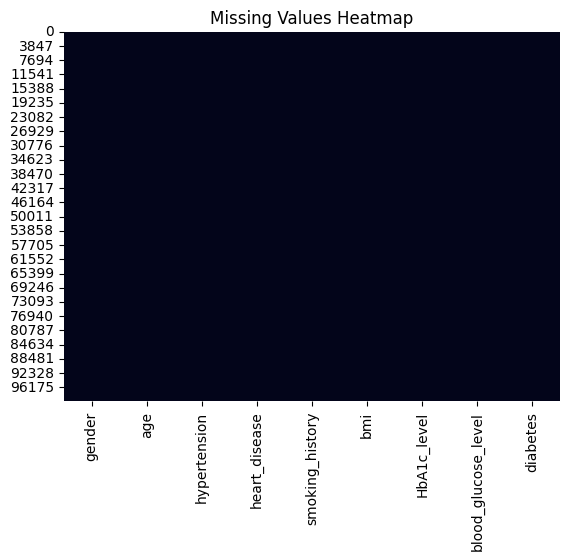

In [ ]:
# Visualize missing values
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

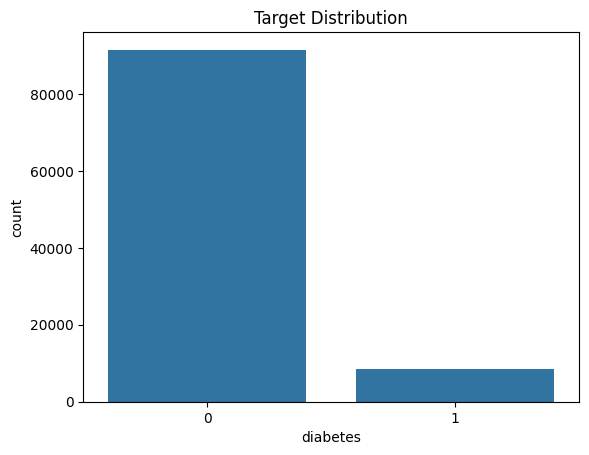

In [ ]:
# Visualize target distribution
target_column = 'diabetes'
is_classification = True

sns.countplot(x=target_column, data=df)
plt.title("Target Distribution")
plt.show()

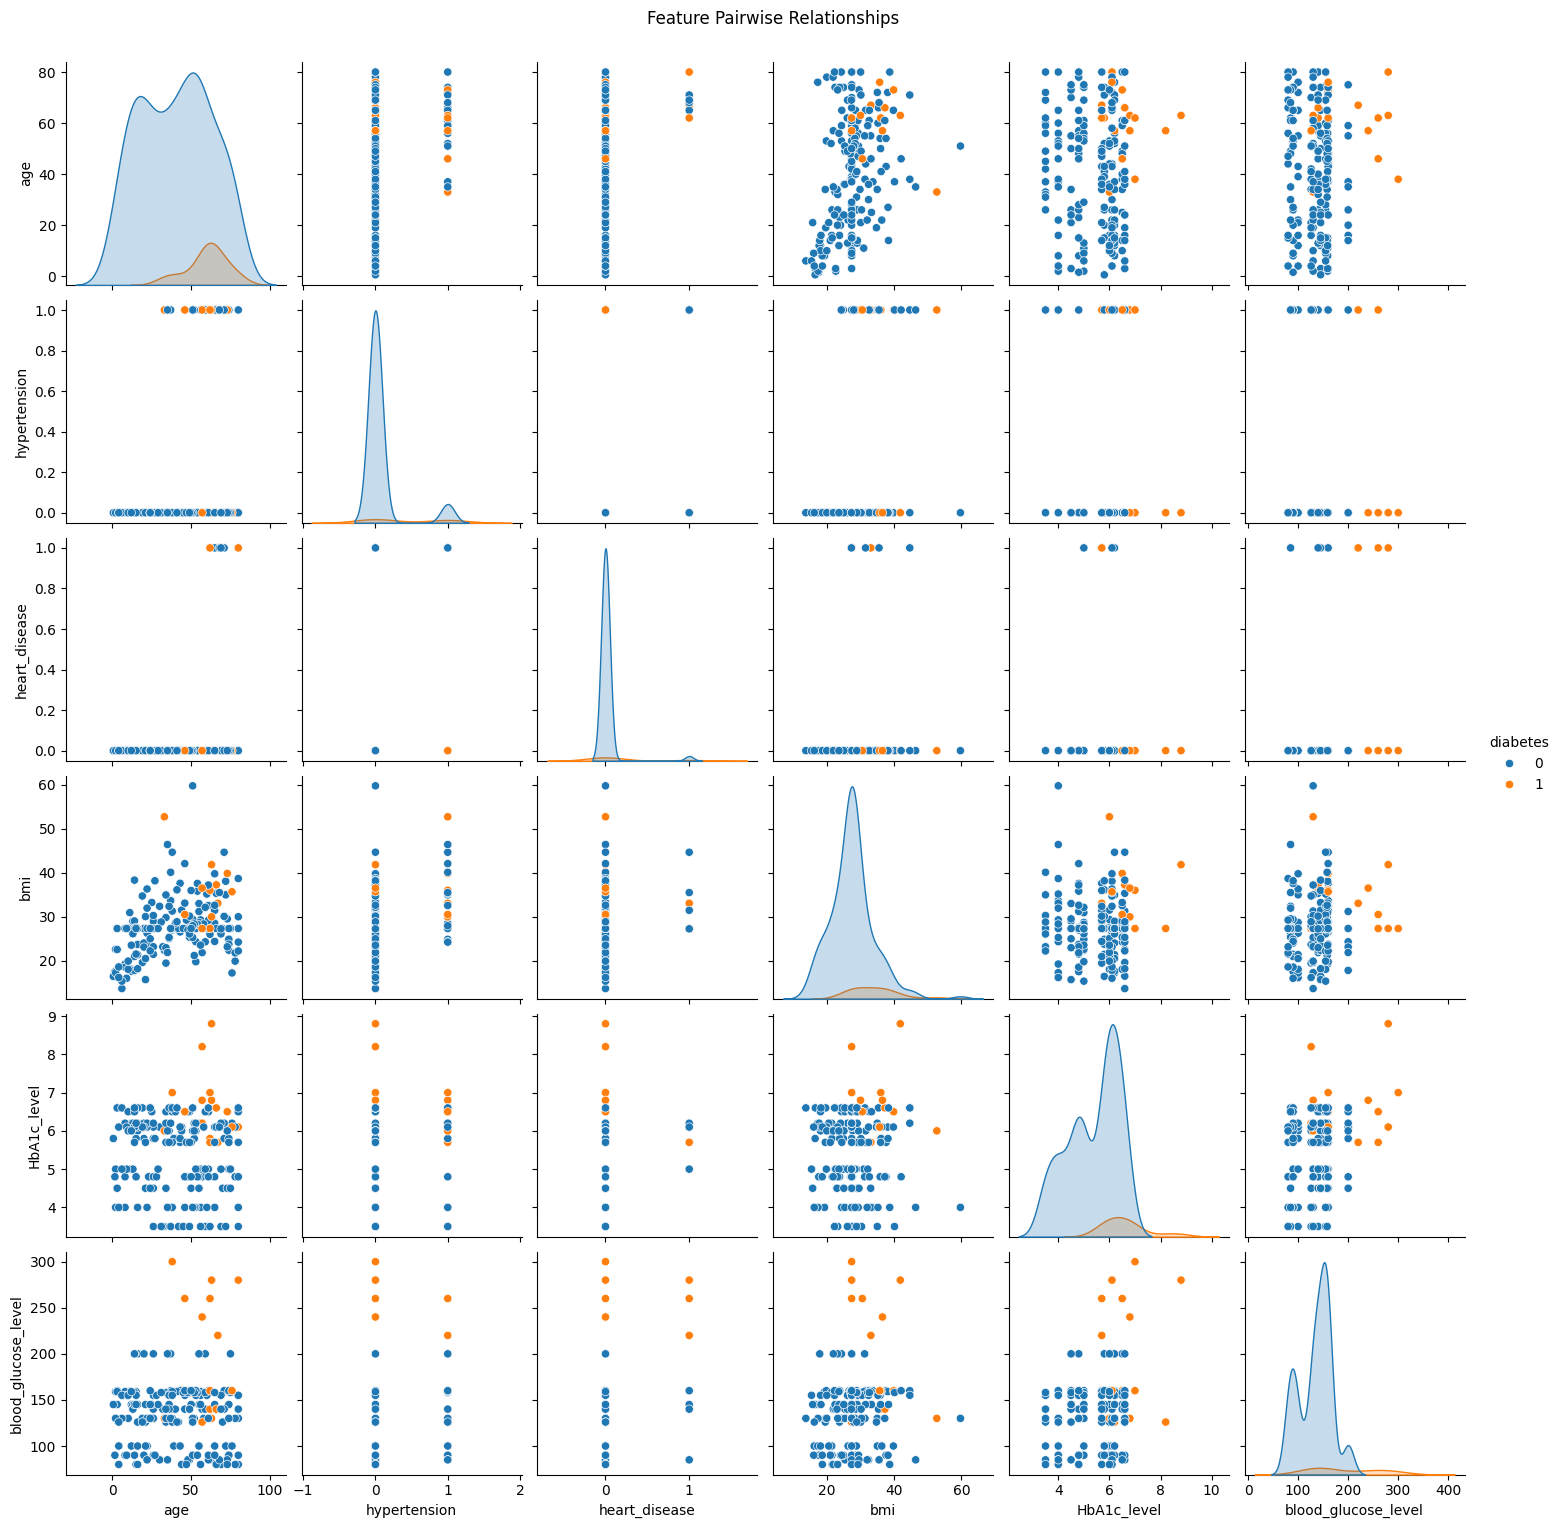

In [ ]:
# More EDA
sns.pairplot(df.sample(200), hue=target_column)
plt.suptitle("Feature Pairwise Relationships", y=1.02)
plt.show()

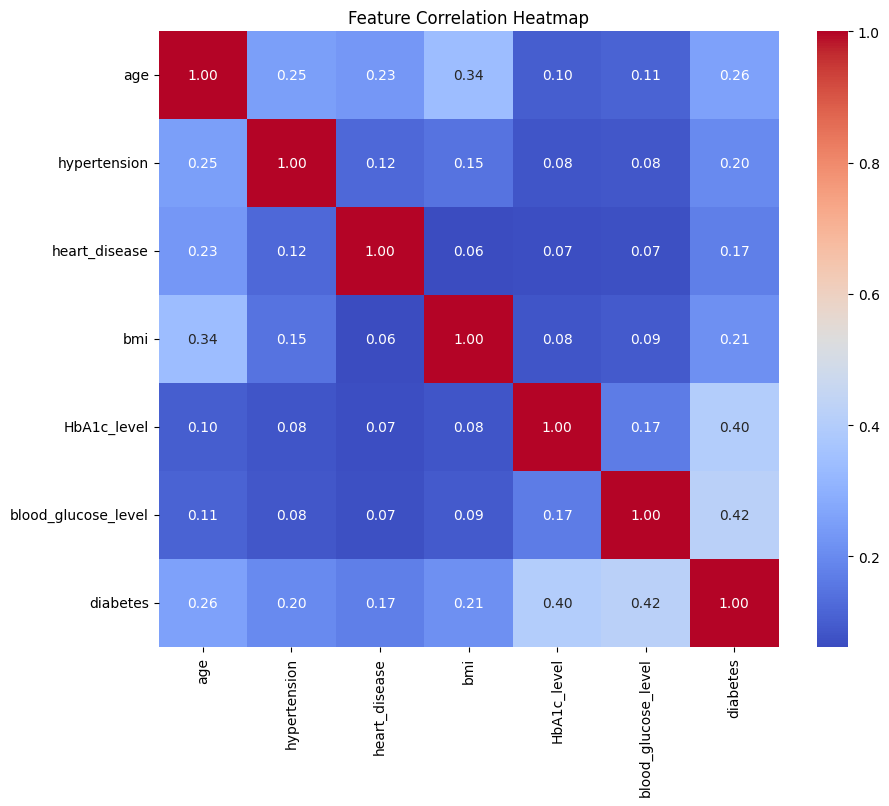

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# === Data Preprocessing ===
if df.select_dtypes(include='object').shape[1] > 0:
    df = df.fillna('unknown')
    for col in df.select_dtypes(include='object'):
        df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=[target_column])
y = df[target_column]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Class distribution after SMOTE:
 diabetes
0    91500
1    91500
Name: count, dtype: int64


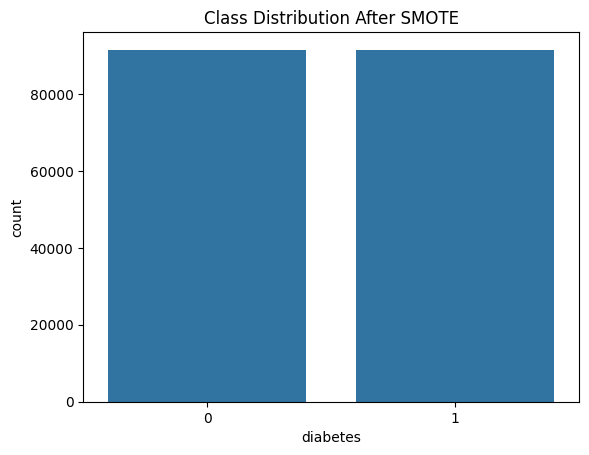

In [ ]:
# Balance classes
if is_classification:
    smote = SMOTE(random_state=42)
    X_scaled, y = smote.fit_resample(X_scaled, y)

    # Visualize class distribution after SMOTE
    print("Class distribution after SMOTE:\n", pd.Series(y).value_counts())
    sns.countplot(x=y)
    plt.title("Class Distribution After SMOTE")
    plt.show()

In [ ]:
# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# === Define Models ===
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

results = []  # Collect model comparison info
cv_scores_dict = {}  # For combined CV boxplot

In [ ]:
# === Hyperparameter Tuning ===
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]}
}

best_models = {}

for name, model in models.items():
    print(f"\n--- Tuning {name} ---")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='f1')
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print("Best Params:", grid.best_params_)


--- Tuning Logistic Regression ---
Best Params: {'C': 0.01}

--- Tuning Decision Tree ---
Best Params: {'max_depth': 10, 'min_samples_split': 2}

--- Tuning Random Forest ---
Best Params: {'max_depth': None, 'n_estimators': 100}



=== Logistic Regression ===
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89     18293
           1       0.89      0.88      0.89     18307

    accuracy                           0.89     36600
   macro avg       0.89      0.89      0.89     36600
weighted avg       0.89      0.89      0.89     36600



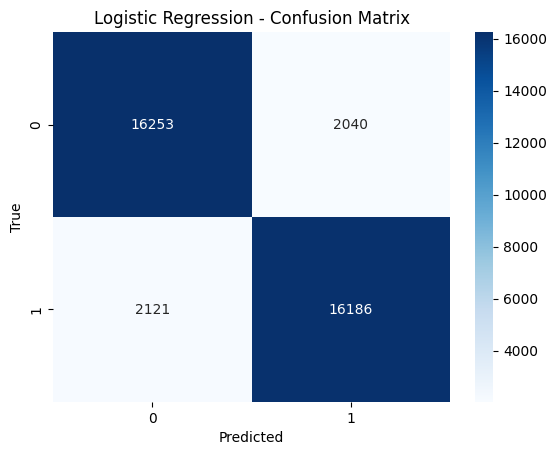


=== Decision Tree ===
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     18293
           1       0.92      0.92      0.92     18307

    accuracy                           0.92     36600
   macro avg       0.92      0.92      0.92     36600
weighted avg       0.92      0.92      0.92     36600



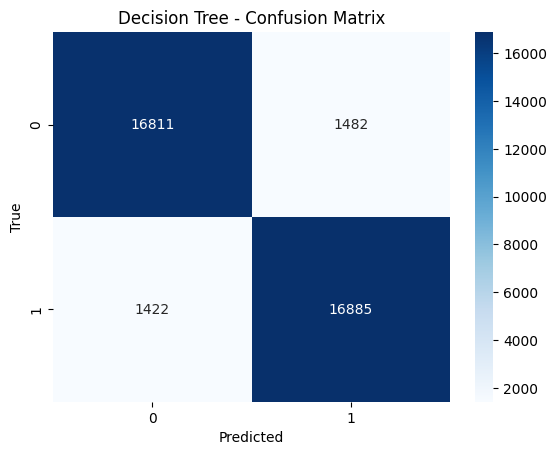


=== Random Forest ===
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     18293
           1       0.98      0.98      0.98     18307

    accuracy                           0.98     36600
   macro avg       0.98      0.98      0.98     36600
weighted avg       0.98      0.98      0.98     36600



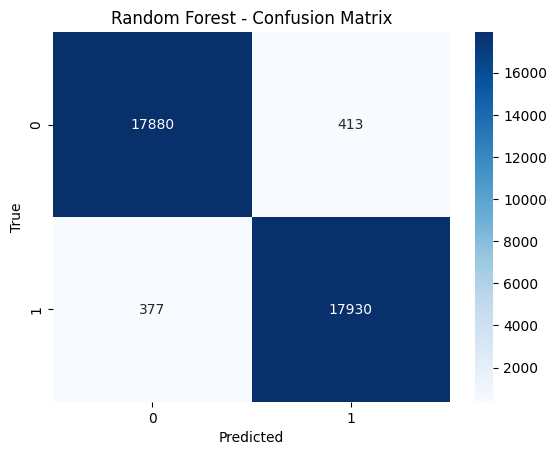

In [ ]:
# === Train and Evaluate Each Model ===
for name, model in best_models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Collect results
    results.append({
        'Model': name,
        'Train Accuracy': model.score(X_train, y_train),
        'Test Accuracy': model.score(X_test, y_test),
        'Train F1': f1_score(y_train, model.predict(X_train)),
        'Test F1': f1_score(y_test, y_pred),
        'Mean F1 CV Score': cv_scores_dict[name].mean() # Use the mean CV score calculated previously
    })


🔍 Cross-Validation Results for Logistic Regression
5-Fold CV F1 Scores: [0.88868173 0.88585574 0.88617797 0.88431018 0.88397548]
Mean F1 Score: 0.8858


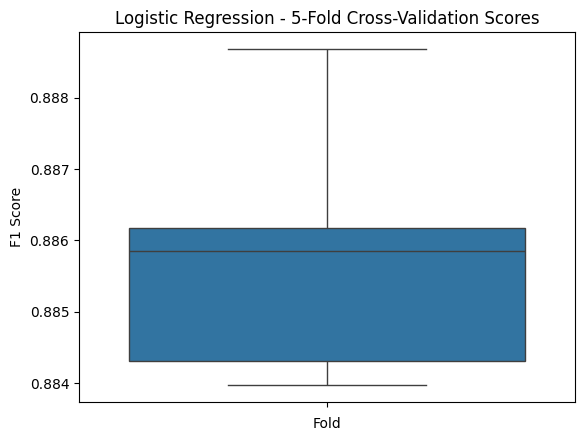


🔍 Cross-Validation Results for Decision Tree
5-Fold CV F1 Scores: [0.89834542 0.92272178 0.92517378 0.92304376 0.92210003]
Mean F1 Score: 0.9183


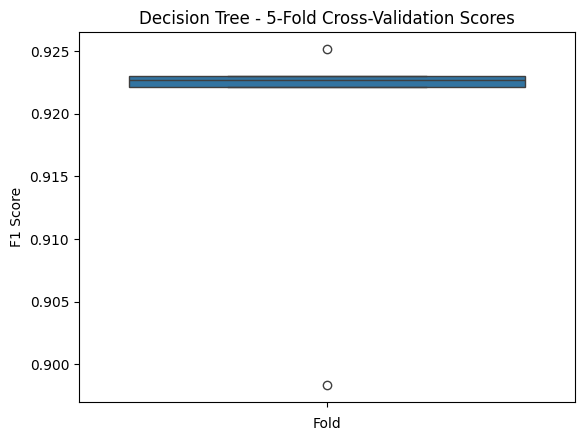


🔍 Cross-Validation Results for Random Forest
5-Fold CV F1 Scores: [0.95307653 0.98528096 0.98480704 0.98383997 0.98438601]
Mean F1 Score: 0.9783


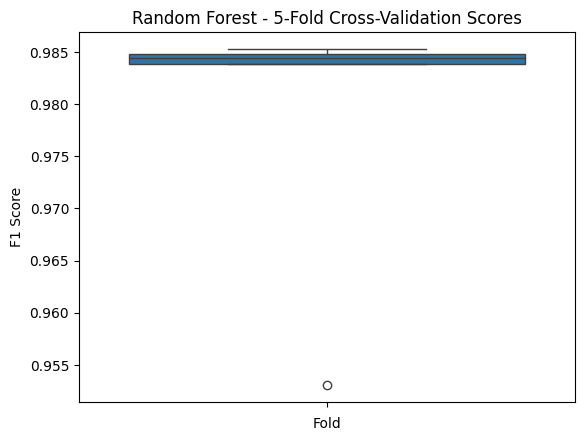

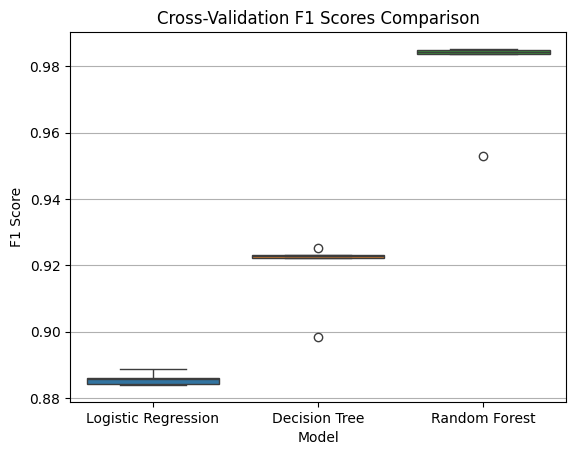

In [ ]:
# Collect CV scores for all models for a unified boxplot
cv_scores_dict = {}

for name, model in best_models.items():
    print(f"\n🔍 Cross-Validation Results for {name}")
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1')
    mean_f1 = np.mean(cv_scores)
    print(f"5-Fold CV F1 Scores: {cv_scores}")
    print(f"Mean F1 Score: {mean_f1:.4f}")

    # Save for later comparison
    cv_scores_dict[name] = cv_scores

    # Also keep doing individual plots if you want
    sns.boxplot(data=cv_scores)
    plt.title(f"{name} - 5-Fold Cross-Validation Scores")
    plt.xlabel("Fold")
    plt.ylabel("F1 Score")
    plt.show()

# Combined boxplot for comparison
cv_df = pd.DataFrame(cv_scores_dict)
sns.boxplot(data=cv_df)
plt.title("Cross-Validation F1 Scores Comparison")
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.grid(axis='y')
plt.show()


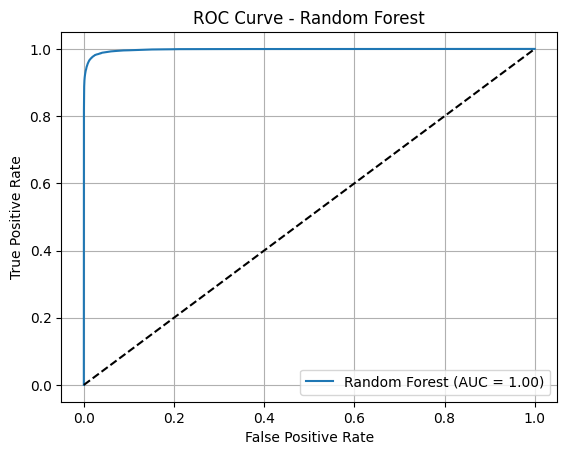

In [ ]:
    # AUC-ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
    # Overfitting Check
    train_pred = model.predict(X_train)
    train_score = f1_score(y_train, train_pred)
    test_score = f1_score(y_test, y_pred)
    print("Training Accuracy:", model.score(X_train, y_train))
    print("Training F1 Score:", train_score)
    print("Test Accuracy:", model.score(X_test, y_test))
    print("Test F1 Score:", test_score)


Training Accuracy: 0.9995696721311476
Training F1 Score: 0.9995695162866338
Test Accuracy: 0.9784153005464481
Test F1 Score: 0.9784447476125512


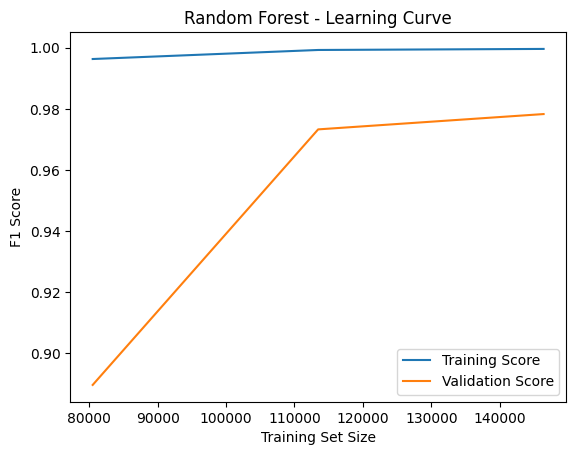

In [ ]:
    # Learning Curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_scaled, y, cv=5, scoring='f1', n_jobs=-1)
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Score')
    plt.title(f"{name} - Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.show()


=== Model Comparison Summary ===
                 Model  Train Accuracy  Test Accuracy  Train F1   Test F1  \
0  Logistic Regression        0.886100       0.886311  0.885853  0.886103   
1        Decision Tree        0.921885       0.920656  0.922048  0.920816   
2        Random Forest        0.999570       0.978415  0.999570  0.978445   

   Mean F1 CV Score  
0          0.885800  
1          0.918277  
2          0.978278  


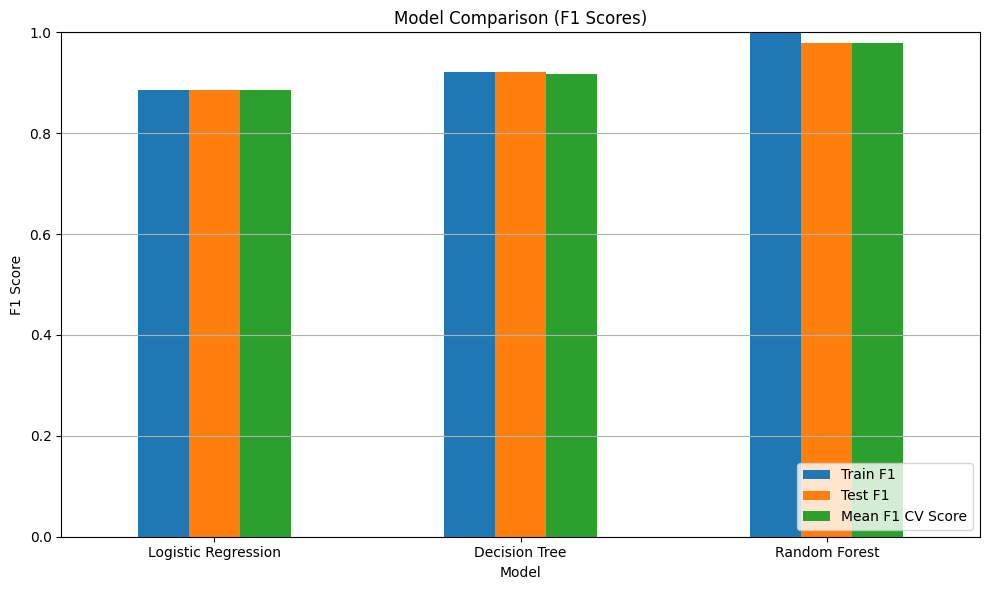

In [ ]:
# === Final Model Comparison ===
results_df = pd.DataFrame(results)
print("\n=== Model Comparison Summary ===")
print(results_df)

results_df = results_df.set_index('Model')
results_df[['Train F1', 'Test F1', 'Mean F1 CV Score']].plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison (F1 Scores)")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

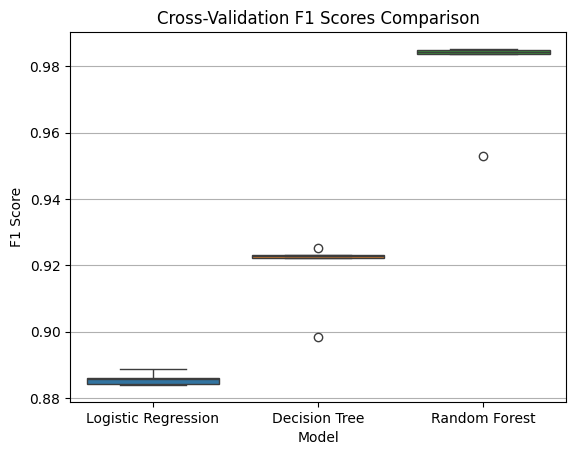

In [ ]:
# === Combined CV Boxplot ===
cv_df = pd.DataFrame(cv_scores_dict)
sns.boxplot(data=cv_df)
plt.title("Cross-Validation F1 Scores Comparison")
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.grid(axis='y')
plt.show()

In [ ]:
# === LIME Explanation for All Models ===
print("\n=== LIME Model Interpretations ===")
for name, model in best_models.items():
    print(f"\nExplaining {name} with LIME...")

    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train,
        feature_names=X.columns,
        class_names=['Non-Diabetic', 'Diabetic'],
        discretize_continuous=True
    )

    idx = 1  # Change index to test different samples
    exp = explainer.explain_instance(X_test[idx], model.predict_proba)
    print(f"Explanation for sample {idx} using {name}:")
    exp.show_in_notebook(show_table=True, show_all=False)


=== LIME Model Interpretations ===

Explaining Logistic Regression with LIME...
Explanation for sample 1 using Logistic Regression:



Explaining Decision Tree with LIME...
Explanation for sample 1 using Decision Tree:



Explaining Random Forest with LIME...
Explanation for sample 1 using Random Forest:
